# Import libraries

In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook
%matplotlib inline 
import cv2

# Importing the haarcascade library from the local host

In [3]:
FACE_DETECTION_FOLDER = 'C:/Users/tejru/Downloads/Deepfake_Detection_Project-master/input/haar-cascades-for-face-detection'
print(f"Face detection resources: {os.listdir(FACE_DETECTION_FOLDER)}")

Face detection resources: ['haarcascade_eye.xml', 'haarcascade_eye_tree_eyeglasses.xml', 'haarcascade_frontalface_alt.xml', 'haarcascade_frontalface_alt2.xml', 'haarcascade_frontalface_alt_tree.xml', 'haarcascade_frontalface_default.xml', 'haarcascade_fullbody.xml', 'haarcascade_profileface.xml', 'haarcascade_smile.xml', 'haarcascade_upperbody.xml']


# Data Exploration

In [2]:
DATA_FOLDER = 'C:/Users/tejru/Downloads/deepfake-detection-challenge'
TRAIN_SAMPLE_FOLDER = 'train_sample_videos'
TEST_FOLDER = 'test_videos'
print(f"Train samples: {len(os.listdir(os.path.join(DATA_FOLDER,TRAIN_SAMPLE_FOLDER)))}")
print(f"Test samples: {len(os.listdir(os.path.join(DATA_FOLDER, TEST_FOLDER)))}")

Train samples: 401
Test samples: 400


In [4]:

train_list = list(os.listdir(os.path.join(DATA_FOLDER, TRAIN_SAMPLE_FOLDER)))
ext_dict = []
for file in train_list:
    file_ext = file.split('.')[1]
    if (file_ext not in ext_dict):
        ext_dict.append(file_ext)
print(f"Extensions: {ext_dict}")

Extensions: ['mp4', 'json']


In [5]:
for file_ext in ext_dict:
    print(f"Files with extension `{file_ext}`: {len([file for file in train_list if  file.endswith(file_ext)])}")


Files with extension `mp4`: 400
Files with extension `json`: 1


In [6]:
json_file = [file for file in train_list if  file.endswith('json')][0]
print(f"JSON file: {json_file}")

JSON file: metadata.json


In [7]:

def get_meta_from_json(path):
    df = pd.read_json(os.path.join(DATA_FOLDER, path, json_file))
    df = df.T
    return df

meta_train_df = get_meta_from_json(TRAIN_SAMPLE_FOLDER)
meta_train_df.head()

,label,split,original
aagfhgtpmv.mp4,FAKE,train,vudstovrck.mp4
aapnvogymq.mp4,FAKE,train,jdubbvfswz.mp4
abarnvbtwb.mp4,REAL,train,None
abofeumbvv.mp4,FAKE,train,atvmxvwyns.mp4
abqwwspghj.mp4,FAKE,train,qzimuostzz.mp4


## Plot function is created for counting the real and fake videos in training dataset. 

In [8]:
def plot_count(feature, title, df, size=1):
    f, ax = plt.subplots(1,1, figsize=(4*size,4))
    total = float(len(df))
    g = sns.countplot(df[feature], order = df[feature].value_counts().index[:20], palette='Set3')
    g.set_title("Number and percentage of {}".format(title))
    if(size > 2):
        plt.xticks(rotation=90, size=8)
    for p in ax.patches:
        height = p.get_height()
        ax.text(p.get_x()+p.get_width()/2.,
                height + 3,
                '{:1.2f}%'.format(100*height/total),
                ha="center") 
    plt.show()

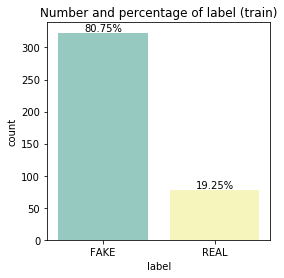

In [9]:
plot_count('label', 'label (train)', meta_train_df)

In [10]:
fake_train_sample_video = list(meta_train_df.loc[meta_train_df.label=='FAKE'].sample(3).index)
fake_train_sample_video

['egbbcxcuqy.mp4', 'eiwopxzjfn.mp4', 'apgjqzkoma.mp4']

# Function to convert the images into videos    

In [20]:
def display_image_from_video(video_path):
    capture_image = cv2.VideoCapture(video_path) 
    ret, frame = capture_image.read()
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(111)
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    ax.imshow(frame)

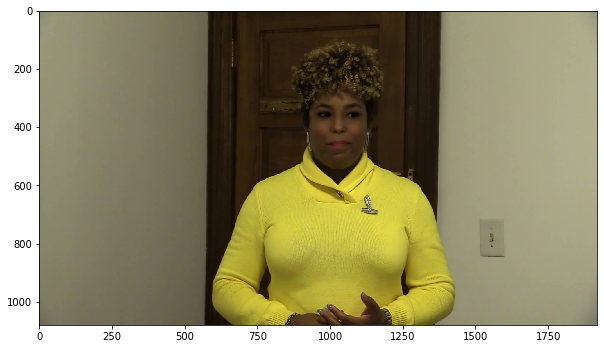

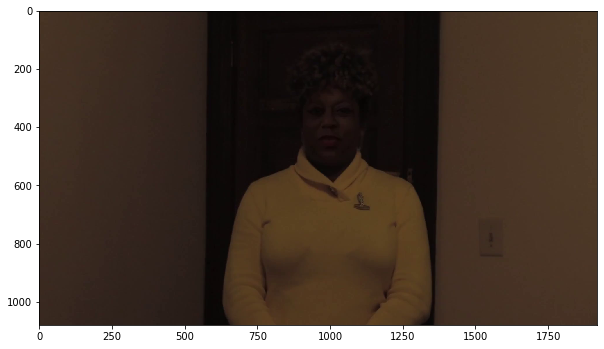

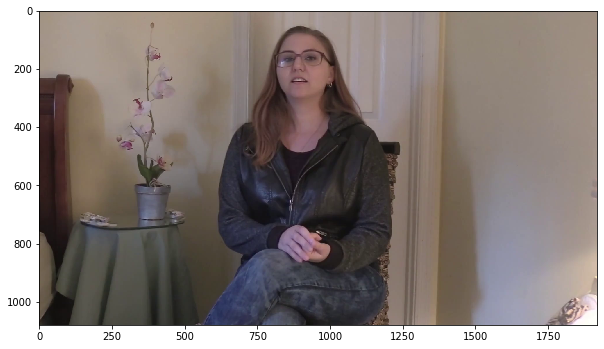

In [15]:

for video_file in fake_train_sample_video:
    display_image_from_video(os.path.join(DATA_FOLDER, TRAIN_SAMPLE_FOLDER, video_file))

In [17]:
meta_train_df['original'].value_counts()[0:5]


atvmxvwyns.mp4    6
meawmsgiti.mp4    6
qeumxirsme.mp4    5
kgbkktcjxf.mp4    5
ywvlvpvroj.mp4    4
Name: original, dtype: int64

# function to display frames from the video list   

In [23]:
def display_image_from_video_list(video_path_list, video_folder=TRAIN_SAMPLE_FOLDER):
    plt.figure()
    fig, ax = plt.subplots(2,3,figsize=(16,8))
    for i, video_file in enumerate(video_path_list[0:6]):
        video_path = os.path.join(DATA_FOLDER, video_folder,video_file)
        capture_image = cv2.VideoCapture(video_path) 
        ret, frame = capture_image.read()
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        ax[i//3, i%3].imshow(frame)
        ax[i//3, i%3].set_title(f"Video: {video_file}")
        ax[i//3, i%3].axis('on')

<Figure size 432x288 with 0 Axes>

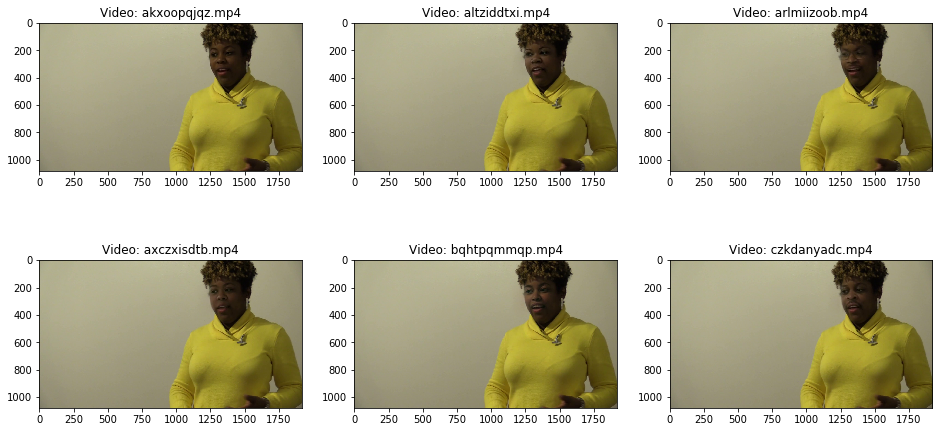

In [24]:
same_original_fake_train_sample_video = list(meta_train_df.loc[meta_train_df.original=='meawmsgiti.mp4'].index)
display_image_from_video_list(same_original_fake_train_sample_video)

# Face detection

## Object detection class is created to cascade the facial features from the images.

In [27]:

class ObjectDetector():
    def __init__(self,object_cascade_path):
        self.objectCascade=cv2.CascadeClassifier(object_cascade_path)


    def detect(self, image, scale_factor=1.3,
               min_neighbors=5,
               min_size=(20,20)):
        rects=self.objectCascade.detectMultiScale(image,
                                                scaleFactor=scale_factor,
                                                minNeighbors=min_neighbors,
                                                minSize=min_size)
        return rects

# objects for the facial features like smile, eye, smile, and front face are created

In [28]:
frontal_cascade_path= os.path.join(FACE_DETECTION_FOLDER,'haarcascade_frontalface_default.xml')
eye_cascade_path= os.path.join(FACE_DETECTION_FOLDER,'haarcascade_eye.xml')
profile_cascade_path= os.path.join(FACE_DETECTION_FOLDER,'haarcascade_profileface.xml')
smile_cascade_path= os.path.join(FACE_DETECTION_FOLDER,'haarcascade_smile.xml')

fd=ObjectDetector(frontal_cascade_path)

ed=ObjectDetector(eye_cascade_path)

pd=ObjectDetector(profile_cascade_path)

sd=ObjectDetector(smile_cascade_path)

# class to extract facial features from the training videos

In [33]:
def extract_image_objects(video_file, video_set_folder=TRAIN_SAMPLE_FOLDER):
    video_path = os.path.join(DATA_FOLDER, video_set_folder,video_file)
    capture_image = cv2.VideoCapture(video_path) 
    ret, frame = capture_image.read()
    #frame = cv.cvtColor(frame, cv.COLOR_BGR2RGB)
    detect(image=frame, 
            scale_factor=1.3, 
            min_neighbors=5, 
            min_size=(50, 50))

# CNN model

In [35]:
def display(img):
    
    fig = plt.figure(figsize=(8,8))
    ax = fig.add_subplot(111)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    ax.imshow(img)

In [36]:
rdm = os.path.join(DATA_FOLDER, TRAIN_SAMPLE_FOLDER, meta_train_df.sample().index[0])
rdm

'C:/Users/tejru/Downloads/deepfake-detection-challenge\\train_sample_videos\\ekhacizpah.mp4'

In [37]:

cap = cv2.VideoCapture(rdm)
ret,frame = cap.read()

# Region of interest class to extract the accurate facial features from images

In [41]:
def ROI(img):
    
    face_img = img.copy()
  
    face_rects = face_cascade.detectMultiScale(face_img,scaleFactor=1.3, minNeighbors=5) 
    
    for (x,y,w,h) in face_rects: 
        roi = face_img[y:y+256,x:x+256] 
        
    try:
        return roi
    except:
        return []

# Took only the features with frontal_cascade_path

In [43]:
face_cascade = cv2.CascadeClassifier(frontal_cascade_path)

# Modelling

## All the videos are appended into object called data after applying the roi

In [39]:

data = []

In [44]:
for n,v in enumerate(list(meta_train_df.index)):
    print(n,v)

    cap = cv2.VideoCapture(os.path.join(DATA_FOLDER, TRAIN_SAMPLE_FOLDER,v))
    ret, frame = cap.read()
    if not ret: roi = []
    else: roi = ROI(frame)

    if len(roi) < 1:
        count = 1
        while len(roi) < 1:
            cap.set(cv2.CAP_PROP_POS_MSEC,(count*1000))
            ret,frame = cap.read()
            if ret: roi = ROI(frame)
            count+=1
            if count >= 10:
                break

    data.append(roi)

0 aagfhgtpmv.mp4
1 aapnvogymq.mp4
2 abarnvbtwb.mp4
3 abofeumbvv.mp4
4 abqwwspghj.mp4
5 acifjvzvpm.mp4
6 acqfdwsrhi.mp4
7 acxnxvbsxk.mp4
8 acxwigylke.mp4
9 aczrgyricp.mp4
10 adhsbajydo.mp4
11 adohikbdaz.mp4
12 adylbeequz.mp4
13 aelfnikyqj.mp4
14 aelzhcnwgf.mp4
15 aettqgevhz.mp4
16 aevrfsexku.mp4
17 afoovlsmtx.mp4
18 agdkmztvby.mp4
19 agqphdxmwt.mp4
20 agrmhtjdlk.mp4
21 ahbweevwpv.mp4
22 ahdbuwqxit.mp4
23 ahfazfbntc.mp4
24 ahqqqilsxt.mp4
25 aipfdnwpoo.mp4
26 ajqslcypsw.mp4
27 ajwpjhrbcv.mp4
28 aklqzsddfl.mp4
29 aknbdpmgua.mp4
30 aknmpoonls.mp4
31 akvmwkdyuv.mp4
32 akxoopqjqz.mp4
33 akzbnazxtz.mp4
34 aladcziidp.mp4
35 alaijyygdv.mp4
36 alninxcyhg.mp4
37 altziddtxi.mp4
38 alvgwypubw.mp4
39 amaivqofda.mp4
40 amowujxmzc.mp4
41 andaxzscny.mp4
42 aneclqfpbt.mp4
43 anpuvshzoo.mp4
44 aorjvbyxhw.mp4
45 apatcsqejh.mp4
46 apgjqzkoma.mp4
47 apogckdfrz.mp4
48 aqpnvjhuzw.mp4
49 arkroixhey.mp4
50 arlmiizoob.mp4
51 arrhsnjqku.mp4
52 asaxgevnnp.mp4
53 asdpeebotb.mp4
54 aslsvlvpth.mp4
55 asmpfjfzif.mp4
56

In [45]:

for i in range(len(data)):
    if data[i] == []:
        data[i] = np.zeros((256,256,3))
    print(data[i].shape)
    if data[i].shape != (256,256,3):
        data[i] = np.resize(data[i],(256,256,3))

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 177, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 192, 3)
(256, 256, 3)
(256, 181, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 

C:\Users\tejru\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  


In [47]:
label_list = list(meta_train_df.label)

 # splitting of trian data into training and test dataset.

In [48]:
train_images, train_labels, test_images, test_labels = np.asarray(data[:300]), \
    np.asarray(label_list[:300]), np.asarray(data[300:]), np.asarray(label_list[300:])

In [50]:
train_images2, train_labels2 = np.asarray(data), np.asarray(label_list)

In [51]:
print(train_images.shape,train_labels.shape,test_images.shape,test_labels.shape)

(300, 256, 256, 3) (300,) (100, 256, 256, 3) (100,)


In [52]:
print(train_images2.shape,train_labels2.shape)

(400, 256, 256, 3) (400,)


In [53]:
train_images, test_images = train_images / 255.0, test_images / 255.0

In [54]:
train_images2 = train_images2 / 255.0

# Output of a frame from training dataset

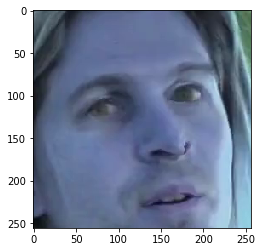

In [55]:
plt.imshow(train_images2[0])

In [56]:

train_labels[0]

'FAKE'

# CNN model implementation

In [58]:
import tensorflow as tf

from tensorflow.keras import datasets, layers, models
import matplotlib.pyplot as plt

In [59]:
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(256,256,3)))
model.add(layers.Conv2D(32, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(256, (3, 3), activation='relu'))
model.add(layers.Conv2D(256, (3, 3), activation='relu'))
model.add(layers.Conv2D(256, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(256, (3, 3), activation='relu'))
model.add(layers.Conv2D(256, (3, 3), activation='relu'))
model.add(layers.Conv2D(256, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(2))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 254, 254, 32)      896       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 252, 252, 32)      9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 126, 126, 32)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 124, 124, 64)      18496     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 122, 122, 64)      36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 61, 61, 64)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 59, 59, 128)       7

In [60]:
train_labels[train_labels == 'FAKE'] = 0
train_labels[train_labels == 'REAL'] = 1

In [61]:

test_labels[test_labels == 'FAKE'] = 0
test_labels[test_labels == 'REAL'] = 1

In [62]:
test_labels = test_labels.astype('float64')
train_labels = train_labels.astype('float64')

In [63]:
train_labels2[train_labels2 == 'FAKE'] = 0
train_labels2[train_labels2 == 'REAL'] = 1

train_labels2 = train_labels2.astype('float64')

In [64]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [65]:
test_images2 

Train on 320 samples, validate on 80 samples
Epoch 1/10
320/320 [==============================] - 57s 179ms/sample - loss: 0.6478 - accuracy: 0.8062 - val_loss: 0.6054 - val_accuracy: 0.8125
Epoch 2/10
320/320 [==============================] - 58s 181ms/sample - loss: 0.5292 - accuracy: 0.8062 - val_loss: 0.4858 - val_accuracy: 0.8125
Epoch 3/10
320/320 [==============================] - 54s 169ms/sample - loss: 0.5133 - accuracy: 0.8062 - val_loss: 0.4977 - val_accuracy: 0.8125
Epoch 4/10
320/320 [==============================] - 54s 169ms/sample - loss: 0.5009 - accuracy: 0.8062 - val_loss: 0.5153 - val_accuracy: 0.8125
Epoch 5/10
320/320 [==============================] - 54s 169ms/sample - loss: 0.5312 - accuracy: 0.8062 - val_loss: 0.4845 - val_accuracy: 0.8125
Epoch 6/10
320/320 [==============================] - 54s 169ms/sample - loss: 0.5156 - accuracy: 0.8062 - val_loss: 0.5166 - val_accuracy: 0.8125
Epoch 7/10
320/320 [==============================] - 55s 172ms/sample - 

# CNN model accuracy

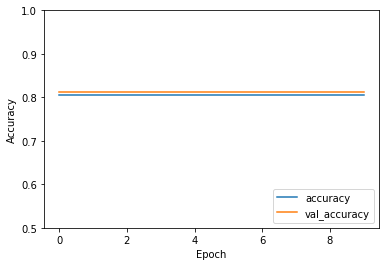

In [66]:

plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

# CNN model loss plot w.r.t epochs

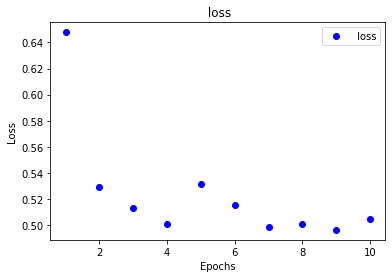

In [70]:
loss = history.history['loss']
#accuracy = history.history['accuracy']

 

epochs = range(1,len(loss)+1)

 

plt.plot(epochs,loss,'bo',label=' loss')
#plt.plot(epochs,accuracy,'b',label='accuracy')
plt.title(' loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [68]:
history.history['accuracy']

[0.80625,
 0.80625,
 0.80625,
 0.80625,
 0.80625,
 0.80625,
 0.80625,
 0.80625,
 0.80625,
 0.80625]

# Training and validation accuracy

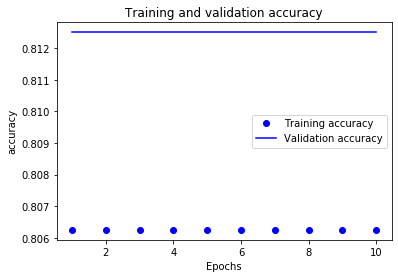

In [71]:
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

 

epochs = range(1,len(accuracy)+1)

 

plt.plot(epochs,accuracy,'bo',label='Training accuracy')
plt.plot(epochs,val_accuracy,'b',label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('accuracy')
plt.legend()
plt.show()

# overall traning loss and accuracy values

In [67]:

test_loss, test_acc = model.evaluate(test_images,  test_labels, verbose=2)

100/100 - 6s - loss: 0.4943 - accuracy: 0.8200


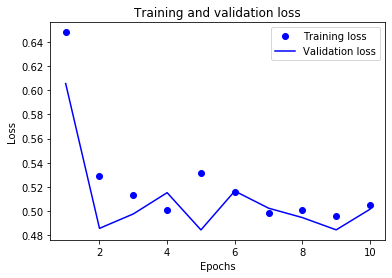

In [72]:
loss = history.history['loss']
val_loss = history.history['val_loss']

 

epochs = range(1,len(loss)+1)

 

plt.plot(epochs,loss,'bo',label='Training loss')
plt.plot(epochs,val_loss,'b',label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

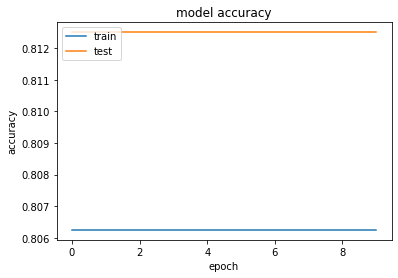

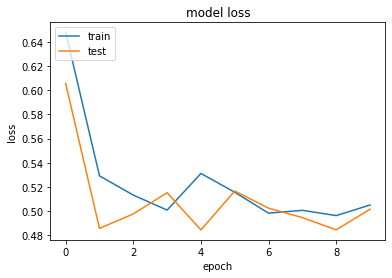

In [94]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

## the training sample reduced with 100 videos 

In [69]:

test_images2 = train_images[:100]
test_labels2 = train_labels[:100]

test_loss, test_acc = model.evaluate(test_images2, test_labels2, verbose=2)

100/100 - 7s - loss: 0.5043 - accuracy: 0.8100


# Parameters of the CNN model are reduced

In [73]:

model2 = models.Sequential()

model2.add(layers.Conv2D(8, (3, 3), activation='relu', input_shape=(256,256,3)))
model2.add(layers.BatchNormalization())
model2.add(layers.MaxPooling2D((2, 2)))
model2.add(layers.Conv2D(8, (5, 5), activation='relu'))
model2.add(layers.BatchNormalization())
model2.add(layers.MaxPooling2D((2, 2)))
model2.add(layers.Conv2D(16, (5, 5), activation='relu'))
model2.add(layers.BatchNormalization())
model2.add(layers.MaxPooling2D((2, 2)))
model2.add(layers.Conv2D(16, (5, 5), activation='relu'))
model2.add(layers.BatchNormalization())
model2.add(layers.MaxPooling2D((4, 4)))

model2.add(layers.Flatten())
model2.add(layers.Dense(16, activation='relu'))
model2.add(layers.Dense(1))

model2.summary()


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_13 (Conv2D)           (None, 254, 254, 8)       224       
_________________________________________________________________
batch_normalization (BatchNo (None, 254, 254, 8)       32        
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 127, 127, 8)       0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 123, 123, 8)       1608      
_________________________________________________________________
batch_normalization_1 (Batch (None, 123, 123, 8)       32        
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 61, 61, 8)         0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 57, 57, 16)       

In [74]:

model2.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])


# hyper parameterized model is used for evaluating th AUC value

In [88]:

history_1 = model.fit(train_images2, train_labels2, epochs=10,
                    validation_split=0.2)

Train on 320 samples, validate on 80 samples
Epoch 1/10
320/320 [==============================] - 67s 209ms/sample - loss: 0.7252 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 258.0000 - fn: 62.0000 - accuracy: 0.8062 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.4962 - val_loss: 0.6931 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 65.0000 - val_fn: 15.0000 - val_accuracy: 0.8125 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.5000
Epoch 2/10
320/320 [==============================] - 57s 179ms/sample - loss: 0.6931 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 258.0000 - fn: 62.0000 - accuracy: 0.8062 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.5000 - val_loss: 0.6931 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 65.0000 - val_fn: 15.0000 - val_accuracy: 0.8125 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.5000
Epoch 3/10
320/320 [==============================] - 64s 201ms/sample - loss: 0.6931 - tp: 0.0000e+00 - fp: 0.0000e+00

In [89]:

import tensorflow as tf

from tensorflow.keras import datasets, layers, models, metrics
import matplotlib.pyplot as plt

In [91]:
class_weight = {0: 1.,
                1: 15.}
METRICS = [
      metrics.TruePositives(name='tp'),
      metrics.FalsePositives(name='fp'),
      metrics.TrueNegatives(name='tn'),
      metrics.FalseNegatives(name='fn'), 
      metrics.BinaryAccuracy(name='accuracy'),
      metrics.Precision(name='precision'),
      metrics.Recall(name='recall'),
      metrics.AUC(name='auc'),
]


In [110]:

tf.keras.backend.clear_session()

In [114]:
import pandas as pd

In [117]:

model_history[0][['loss','auc','accuracy','val_loss','val_auc','val_accuracy']]

,loss,auc,accuracy,val_loss,val_auc,val_accuracy
0,0.725248,0.496187,0.80625,0.693147,0.5,0.8125
1,0.693147,0.500000,0.80625,0.693147,0.5,0.8125
2,0.693147,0.500000,0.80625,0.693147,0.5,0.8125
3,0.693147,0.500000,0.80625,0.693147,0.5,0.8125
4,0.693147,0.500000,0.80625,0.693147,0.5,0.8125
5,0.693147,0.500000,0.80625,0.693147,0.5,0.8125
6,0.693147,0.500000,0.80625,0.693147,0.5,0.8125
7,0.693147,0.500000,0.80625,0.693147,0.5,0.8125
8,0.693147,0.500000,0.80625,0.693147,0.5,0.8125
9,0.693147,0.500000,0.80625,0.693147,0.5,0.8125


# For the initial iteration the models AUc value is about 0.49 and then it remained constant

In [156]:
model_history[1][['loss','auc','accuracy','val_loss','val_auc','val_accuracy']]

,loss,auc,accuracy,val_loss,val_auc,val_accuracy
0,0.693147,0.5,0.80625,0.693147,0.5,0.8125
1,0.693147,0.5,0.80625,0.693147,0.5,0.8125
2,0.693147,0.5,0.80625,0.693147,0.5,0.8125
3,0.693147,0.5,0.80625,0.693147,0.5,0.8125
4,0.693147,0.5,0.80625,0.693147,0.5,0.8125
5,0.693147,0.5,0.80625,0.693147,0.5,0.8125
6,0.693147,0.5,0.80625,0.693147,0.5,0.8125
7,0.693147,0.5,0.80625,0.693147,0.5,0.8125
8,0.693147,0.5,0.80625,0.693147,0.5,0.8125
9,0.693147,0.5,0.80625,0.693147,0.5,0.8125


In [118]:
model_history[0][['val_tp','val_fp','val_tn','val_fn']]

,val_tp,val_fp,val_tn,val_fn
0,0.0,0.0,65.0,15.0
1,0.0,0.0,65.0,15.0
2,0.0,0.0,65.0,15.0
3,0.0,0.0,65.0,15.0
4,0.0,0.0,65.0,15.0
5,0.0,0.0,65.0,15.0
6,0.0,0.0,65.0,15.0
7,0.0,0.0,65.0,15.0
8,0.0,0.0,65.0,15.0
9,0.0,0.0,65.0,15.0


In [135]:
class_weight = {0: 1.,
                1: 1.}
history_3 = model.fit(train_images2, train_labels2, epochs=10,
                    validation_split=0.2)

Train on 320 samples, validate on 80 samples
Epoch 1/10
320/320 [==============================] - 25s 78ms/sample - loss: 0.6931 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 258.0000 - fn: 62.0000 - accuracy: 0.8062 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.5000 - val_loss: 0.6931 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 65.0000 - val_fn: 15.0000 - val_accuracy: 0.8125 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.5000
Epoch 2/10
320/320 [==============================] - 24s 75ms/sample - loss: 0.6931 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 258.0000 - fn: 62.0000 - accuracy: 0.8062 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.5000 - val_loss: 0.6931 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 65.0000 - val_fn: 15.0000 - val_accuracy: 0.8125 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.5000
Epoch 3/10
320/320 [==============================] - 24s 75ms/sample - loss: 0.6931 - tp: 0.0000e+00 - fp: 0.0000e+00 - 

In [138]:

class_weight = {0: 1.,
                1: 5.}
history4 = model.fit(train_images, train_labels, epochs=10,class_weight=class_weight)

  ...
    to  
  ['...']
Train on 300 samples
Epoch 1/10
300/300 [==============================] - 29s 97ms/sample - loss: 1.2384 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 241.0000 - fn: 59.0000 - accuracy: 0.8033 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.5000
Epoch 2/10
300/300 [==============================] - 52s 172ms/sample - loss: 1.2384 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 241.0000 - fn: 59.0000 - accuracy: 0.8033 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.5000
Epoch 3/10
300/300 [==============================] - 53s 176ms/sample - loss: 1.2384 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 241.0000 - fn: 59.0000 - accuracy: 0.8033 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.5000
Epoch 4/10
300/300 [==============================] - 51s 171ms/sample - loss: 1.2384 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 241.0000 - fn: 59.0000 - accuracy: 0.8033 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.5000
Epoch 5/10
300/300 [===========================

In [140]:
class_weight = {0: 1.,
                1: 10.}
history5 = model.fit(train_images, train_labels, epochs=10,class_weight=class_weight)

  ...
    to  
  ['...']
Train on 300 samples
Epoch 1/10
300/300 [==============================] - 54s 179ms/sample - loss: 1.9200 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 241.0000 - fn: 59.0000 - accuracy: 0.8033 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.5000
Epoch 2/10
300/300 [==============================] - 53s 178ms/sample - loss: 1.9200 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 241.0000 - fn: 59.0000 - accuracy: 0.8033 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.5000
Epoch 3/10
300/300 [==============================] - 55s 183ms/sample - loss: 1.9200 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 241.0000 - fn: 59.0000 - accuracy: 0.8033 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.5000
Epoch 4/10
300/300 [==============================] - 54s 179ms/sample - loss: 1.9200 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 241.0000 - fn: 59.0000 - accuracy: 0.8033 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.5000
Epoch 5/10
300/300 [==========================

In [142]:

class_weight = {0: 1.,
                1: 25.}
history6 = model.fit(train_images, train_labels, epochs=10,class_weight=class_weight)

  ...
    to  
  ['...']
Train on 300 samples
Epoch 1/10
300/300 [==============================] - 52s 173ms/sample - loss: 3.9648 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 241.0000 - fn: 59.0000 - accuracy: 0.8033 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.5000
Epoch 2/10
300/300 [==============================] - 53s 178ms/sample - loss: 3.9648 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 241.0000 - fn: 59.0000 - accuracy: 0.8033 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.5000
Epoch 3/10
300/300 [==============================] - 52s 175ms/sample - loss: 3.9648 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 241.0000 - fn: 59.0000 - accuracy: 0.8033 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.5000
Epoch 4/10
300/300 [==============================] - 57s 190ms/sample - loss: 3.9648 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 241.0000 - fn: 59.0000 - accuracy: 0.8033 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.5000
Epoch 5/10
300/300 [==========================

# Overall the model shown an average AUC value of 0.5

In [144]:
model_history[-1].mean(axis=0)['auc']

0.5

In [145]:
def ave_auc (history_list):
    result = []
    for history in history_list:
        result.append(history.mean(axis=0)['auc'])
    return result

In [143]:
model_history = []

model_history.append(pd.DataFrame.from_dict(history_1.history))
model_history.append(pd.DataFrame.from_dict(history_3.history))
model_history.append(pd.DataFrame.from_dict(history4.history))
model_history.append(pd.DataFrame.from_dict(history5.history))
model_history.append(pd.DataFrame.from_dict(history6.history))

In [121]:
model_history.append(pd.DataFrame.from_dict(history_1.history))

In [123]:
ave_auc(model_history)

[0.4996186554431915, 0.4996186554431915]

Text(0.5, 0, 'class weight ratio')

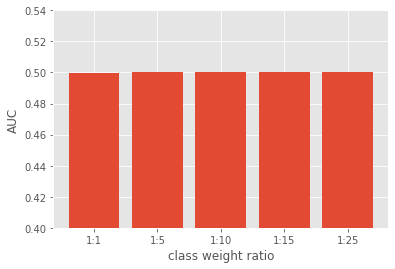

In [146]:

plt.bar([1,2,3,4,5],ave_auc(model_history),tick_label=['1:1','1:5','1:10','1:15','1:25'])
plt.ylim([0.4,0.54])
plt.ylabel('AUC')
plt.xlabel('class weight ratio')

# Overall the model has shown a constat AUC value of 0.5 and accuracy of 0.8 for detecting the deepfake videos